In [1]:
using Pkg; Pkg.activate(@__DIR__);

  Activating project at `~/Documents/SelfConsistentHartreeFock.jl/examples`


In [2]:
using SelfConsistentHartreeFock
import QuantumToolbox as QT
import QuantumCumulants as QC
using HarmonicSteadyState, SecondQuantizedAlgebra
using Symbolics

using Plots, LaTeXStrings, LinearAlgebra

In [3]:
Δsweep = range(-0.01, 0.03, 101)
Kval = 0.01
Fval = 0.002
κval = 0.001

0.001

## Master Equation

In [4]:
function ρ_ss(Δ, F, K, γ; kwargs...)
    N = 50 # cutoff of the Hilbert space dimension
    a = QT.destroy(N) # annihilation operator

    H = -Δ * a' * a + K * a' * a' * a * a - F * (a' + a)
    c_ops = [sqrt(γ) * a]

    solver = QT.SteadyStateLinearSolver()
    ρ_ss = QT.steadystate(H, c_ops; solver, kwargs...) # Hamiltonian and collapse operators
    # real(QT.expect(a' * a, ρ_ss))
end
# function ρ_ss(tt::Tuple)
#     Δ, F = tt
#     ρ_ss(Δ, F, Kval, 0.001)
# end

N = 50 # cutoff of the Hilbert space dimension
a = QT.destroy(N) # a
nm = ρ -> real(QT.expect(a' * a, ρ))
g2m = ρ -> real(QT.expect(a' * a' * a * a, ρ) / QT.expect(a' * a, ρ)^2)

#14 (generic function with 1 method)

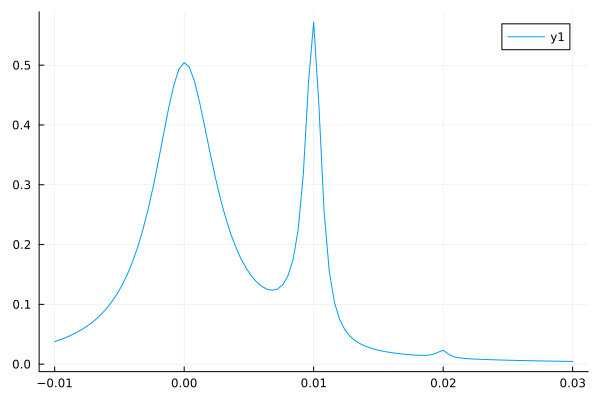

In [5]:
ρv = map(_Δ -> ρ_ss(_Δ, Fval, Kval, κval), Δsweep)
n_q = nm.(ρv)
plot(Δsweep, n_q)

## Meanfield

Solving via TotalDegree homotopy ... 100%|██████████████████████████████████████████████████| Time: 0:00:16


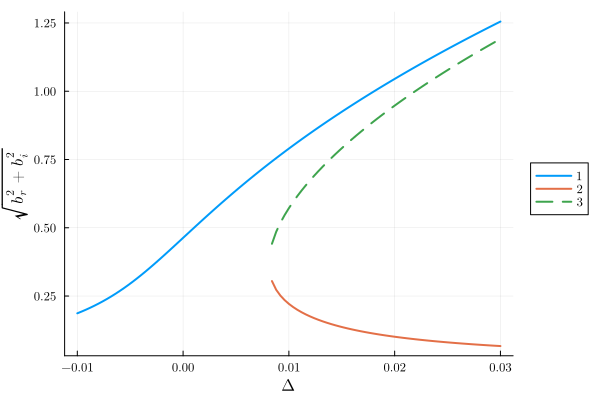

In [6]:
h = QC.FockSpace(:cavity)
QC.@qnumbers b::Destroy(h)
@variables Δ::Real K::Real F::Real κ::Real
param = [Δ, K, F, κ]

H = -Δ * b' * b + K * (b'^2 * b^2) + F * (b' + b)
ops = [b, b']

eqs = QC.complete(QC.meanfield(ops, H, [b]; rates=[κ], order=1))

fixed = (K => Kval, F => Fval, κ => κval)
varied = (Δ => Δsweep)
problem = HarmonicSteadyState.HomotopyContinuationProblem(eqs, param, varied, fixed)

result = get_steady_states(problem, TotalDegree())

branches = get_branches(result, "sqrt(bᵣ^2 + bᵢ^2)", class="stable")

plot(result, y="sqrt(bᵣ^2 + bᵢ^2)")

In [7]:
α_mean_up_c1 = branches[1];
α_mean_down_c1 = branches[2];

Solving via TotalDegree homotopy ... 100%|██████████████████████████████████████████████████| Time: 0:00:04


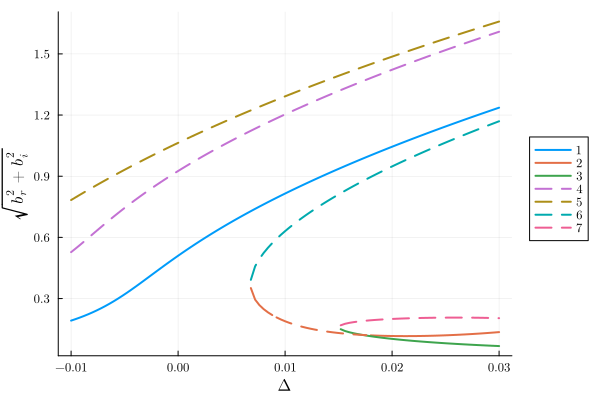

In [8]:
eqs = QC.complete(QC.meanfield(ops, H, [b]; rates=[κ], order=2))

fixed = (K => Kval, F => Fval, κ => κval)
varied = (Δ => Δsweep)
problem = HarmonicSteadyState.HomotopyContinuationProblem(eqs, param, varied, fixed)

result = get_steady_states(problem, TotalDegree())

branches = get_branches(result, "sqrt(bᵣ^2 + bᵢ^2)", class="stable")

plot(result, y="sqrt(bᵣ^2 + bᵢ^2)")

In [9]:
α_mean_up_c2 = branches[1];
α_mean_down_c2_branch_2 = branches[2];
α_mean_down_c2 = branches[3];

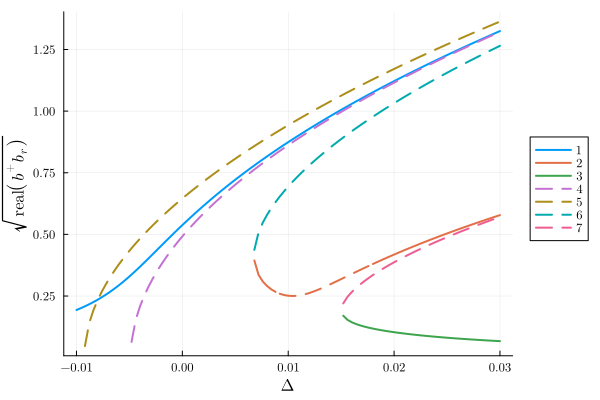

In [10]:
plot(result, y="sqrt(real(b⁺bᵣ))") |> display

branches = get_branches(result, "sqrt(real(b⁺bᵣ))", class="stable")
n_up_c2 = branches[1];
n_down_c2 = branches[2];

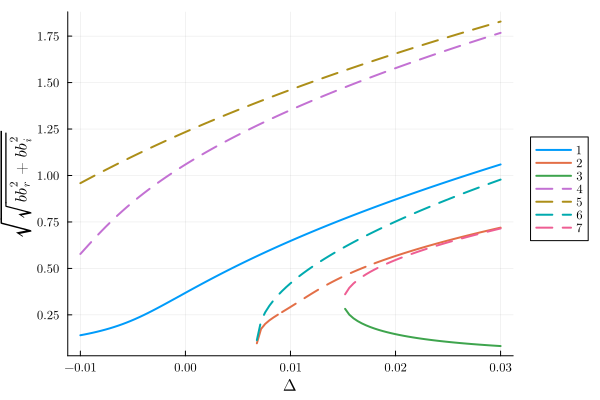

In [11]:
plot(result, y="sqrt(sqrt(bbᵣ^2 + bbᵢ^2))") |> display

branches = get_branches(result, "sqrt(sqrt(bbᵣ^2 + bbᵢ^2))", class="stable")
m_up_c2 = branches[1];
m_down_c2 = branches[2];

## Hartree Fock

In [12]:
h = FockSpace(:cavity)

@qnumbers a::Destroy(h)
@variables F::Real Δ::Real K::Real κ::Real

H = -Δ * a' * a + K * (a'^2 * a^2) + F * (a' + a)

(-Δ*(a′*a)+K*(a′*a′*a*a)+F*(a′)+F*(a))

In [13]:
sys = HartreeFockSystem(H, [a], [κ])

HartreeFockSystem of modes: Destroy[a]

In [14]:
p = Dict(F => Fval, Δ => Δsweep, K => Kval, κ => κval)
problem = IterativeProblem(sys, p)

IterativeProblem

In [15]:
α0 = ComplexF64[rand(ComplexF64), 0.0, 0.0]

3-element Vector{ComplexF64}:
 0.18683469228505156 + 0.19900932136696448im
                 0.0 + 0.0im
                 0.0 + 0.0im

In [16]:
Dampening = 0.2
MaxIter = 10000
ConvergenceMetricThreshold = 1e-12
results_up = parameter_sweep(problem, Δ, Δsweep, α0)
results_down = parameter_sweep(problem, Δ, reverse(Δsweep), α0; Dampening, MaxIter, ConvergenceMetricThreshold);

In [17]:
α_up = map(results_up) do result
    result.αs[1] |> norm
end
α_down = map(results_down) do result
    result.αs[1] |> norm
end

n_up = map(results_up) do result
    result.ns[1]
end
n_down = map(results_down) do result
    result.ns[1]
end

m_up = map(results_up) do result
    result.ms[1] |> norm
end
m_down = map(results_down) do result
    result.ms[1] |> norm
end;

In [18]:
# l = length(amplitude_down)
# plt1 = plot(Δsweep, amplitude_up; xlabel = "Detuning Δ", ylabel = "Amplitude", legend = false)
# plot!(reverse(Δsweep)[1:l], amplitude_down)

# plt2 = plot(Δsweep, fluctuation_up; xlabel = "Detuning Δ", ylabel = "Fluctuation", legend = false)
# plot!(reverse(Δsweep)[1:l], fluctuation_down)

# plt3 = plot(Δsweep, anomalous_up; xlabel = "Detuning Δ", ylabel = "Anomalous", legend = false)
# plot!(reverse(Δsweep)[1:l], anomalous_down)

# plot(plt1, plt2, plt3; layout = (3, 1), size=(500, 600))

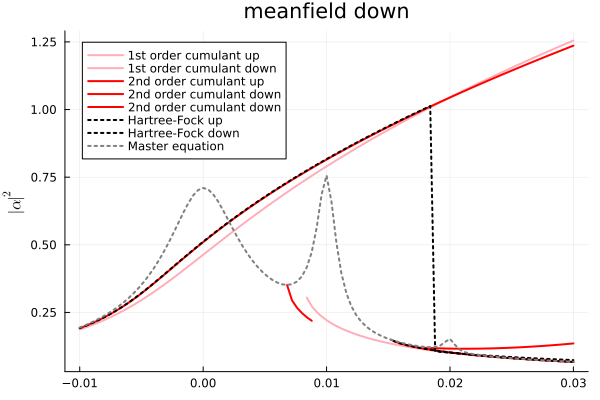

In [19]:
l = length(α_down)
Δsweep_down =  reverse(Δsweep)[1:l]

plt = plot(Δsweep, abs.(α_mean_up_c1); label="1st order cumulant up", lw=2, color=:lightpink1, xlabel="",
    ylabel=L"|α|^2", title="meanfield down")
plot!(plt, Δsweep, abs.(α_mean_down_c1); label="1st order cumulant down", lw=2, color=:lightpink1)
plot!(plt, Δsweep, abs.(α_mean_up_c2); label="2nd order cumulant up", lw=2, color=:red)
plot!(plt, Δsweep, abs.(α_mean_down_c2); label="2nd order cumulant down", lw=2, color=:red)
plot!(plt, Δsweep, abs.(α_mean_down_c2_branch_2); label="2nd order cumulant down", lw=2, color=:red)
plot!(plt, Δsweep, abs.(α_up); label="Hartree-Fock up", lw=2, ls=:dot, color=:black)
plot!(plt, Δsweep_down, abs.(α_down); label="Hartree-Fock down", lw=2, ls=:dot, color=:black)
plot!(plt, Δsweep, sqrt.(n_q); label="Master equation", lw=2, ls=:dot, color=:gray)

plot(plt, size=(600, 400), legend=:topleft)

# plt2 = plot(
#     Δsweep,
#     n_up;
#     label="continuation up",
#     lw=2,
#     xlabel="",
#     ylabel=L"\langle d^\dagger d \rangle",
#     title="fluctuations amplitude",
#     color=:black
# )
# plot!(plt2, Δsweep_down, n_down; label="continuation down", lw=2, color=:black)
# plot!(plt2, Δsweep, abs.(n_up_c2); label="2nd order cumulant up", lw=2, color=:red)
# plot!(plt2, Δsweep, abs.(n_down_c2); label="2nd order cumulant down", lw=2, color=:red)

# plt3 = plot(
#     Δsweep,
#     abs.(m_up);
#     label="continuation up",
#     lw=2,
#     xlabel="Δ",
#     ylabel=L"|\langle d d \rangle|",
#     title="anomalous correlations amplitude",
#     color=:black
# )
# plot!(plt3, Δsweep_down, abs.(m_down); label="continuation down", lw=2, color=:black)
# plot!(plt3, Δsweep, abs.(m_up_c2); label="2nd order cumulant up", lw=2, color=:red)
# plot!(plt3, Δsweep, abs.(m_down_c2); label="2nd order cumulant down", lw=2, color=:red)

# plot(plt, plt2, plt3; layout=(3, 1), size=(700, 900), legend=:topleft)